# Dragon Lake Parking

## About

Dragon Lake Parking (DLP) dataset is collected  by University of California, Berkeley, CA, USA. It is one of the very few dataset that focusing on parking scenarios. "The entire DLP dataset contains 30 scenes, 317, 873 frames, 5, 188 agents, and 15, 383, 737 instances".

### How to Obtain Dataset

The holder of the DLP dataset recommends downloading it directly [from Dryad](https://datadryad.org/dataset/doi:10.5061/dryad.tht76hf5b) without the need for an application. A script for downloading the sample data is also provided.

### How to Obtain Map

The maps of DLP dataset are manually created by Tactics2D, in the format of OpenStreetMap (OSM), labeled in Lanelet2 style. The maps are stored in `data/highD_map`. You can download them from [here](https://github.com/WoodOxen/tactics2d/tree/master/tactics2d/data/DLP_map)

```python
# download_dlp_sample.py

import os
import requests
from tqdm import tqdm


def download_and_rename_file(download_url, folder_path, filename):
    file_path = os.path.join(folder_path, filename)

    if not os.path.exists(file_path):
        response = requests.get(download_url, stream=True)

        if response.status_code == 200:
            total_size_in_bytes = int(response.headers.get("content-length", 0))
            block_size = 1024  # 1 Kilobyte

            if not os.path.exists(folder_path):
                os.makedirs(folder_path)

            progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)
            with open(file_path, "wb") as file:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    file.write(data)
            progress_bar.close()

            if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                print("ERROR, something went wrong")
            print(
                f"File '{filename}' has been downloaded and saved to '{folder_path}'."
            )
        else:
            print(f"Failed to download the file. Status code: {response.status_code}")
    else:
        print(f"File '{filename}' already exists in '{folder_path}'.")


def download_dlp_sample(folder_path):
    url_address = "https://datadryad.org/stash/downloads/file_stream/"
    url_suffixes = ["2654062", "2654066", "2654081", "2654064", "2654065"]
    file_types = ["agents", "frames", "instances", "obstacles", "scene"]

    for i in range(5):
        download_and_rename_file(
            url_address+url_suffixes[i],
            folder_path,
            f"DJI_0012_{file_types}.json"
        )


if __name__ == "__main__":
    folder_path = "dlp_sample"

    download_dlp_sample(folder_path)

```

### Citation

```latex
@inproceedings{shen2022parkpredict+,
    title={Parkpredict+: Multimodal intent and motion prediction for vehicles in parking lots with cnn and transformer},
    author={Shen, Xu and Lacayo, Matthew and Guggilla, Nidhir and Borrelli, Francesco},
    booktitle={2022 IEEE 25th International Conference on Intelligent Transportation Systems (ITSC)},
    pages={3999--4004},
    year={2022},
    organization={IEEE}
}

## Data Analysis

> This part is independently conducted by Tactics2D.

### Trajectory Types in DLP

- `Car`
- `Medium Vehicle`
- `Bus`
- `Motorcycle`
- `Bicycle`
- `Pedestrian`
- `Undefined`

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Setting up parameters for matplotlib
mpl.rcParams.update(
    {
        "figure.dpi": 200,  # 200 for high quality
        "font.family": "DejaVu Sans Mono",
        "font.size": 6,
        "font.stretch": "semi-expanded",
        "animation.html": "jshtml",
        "animation.embed_limit": 5000,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.facecolor": "white",
    }
)
sns.set_palette("Set2")

In [3]:
data_path = "../../data/DLP"
trajectory_class = [
    "Car",
    "Medium Vehicle",
    "Bus",
    "Motorcycle",
    "Bicycle",
    "Pedestrian",
    "Undefined",
]
map_config = {
    "name": "Dragon Lake Parking Lot",
    "osm_file": "DLP.osm",
    "country": "USA",
    "scenario_type": "parking",
    "dataset": "DLP",
    "project_rule": {"proj": "utm", "ellps": "WGS84", "zone": 31, "datum": "WGS84"},
    "gps_origin": [-1.4887438843872076, 0],
    "trajectory_files": [
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
    ],
}
map_range = [-20, 150, -40, 90]

### Proportion of Trajectory Categories

In the DLP dataset, the proportion of pedestrians is notably high, because many individuals park their cars in the lot and then walk to their destinations. The proportion of pedestrians exhibits significant fluctuations across different track files.files.

In [4]:
def plot_class_proportion(data_path: str, class_order: list, map_config: dict):
    df_proportion = pd.DataFrame(0, columns=class_order, index=map_config["trajectory_files"])
    for file_id in map_config["trajectory_files"]:
        agent_path = os.path.join(data_path, "DJI_%04d_agents.json" % file_id)
        with open(agent_path, "r") as f_agent:
            agent_data = json.load(f_agent)
        for _, value in agent_data.items():
            df_proportion.loc[file_id, value["type"]] += 1

        obstacle_path = os.path.join(data_path, "DJI_%04d_obstacles.json" % file_id)
        with open(obstacle_path, "r") as f_obstacle:
            obstacle_data = json.load(f_obstacle)
        for _, value in obstacle_data.items():
            df_proportion.loc[file_id, value["type"]] += 1

    df_proportion = df_proportion.div(df_proportion.sum(axis=1), axis=0)

    df_proportion.plot.barh(stacked=True, title="DLP", colormap="Set2", rot=1)
    plt.gcf().set_size_inches(6, 0.3 * len(df_proportion))
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")

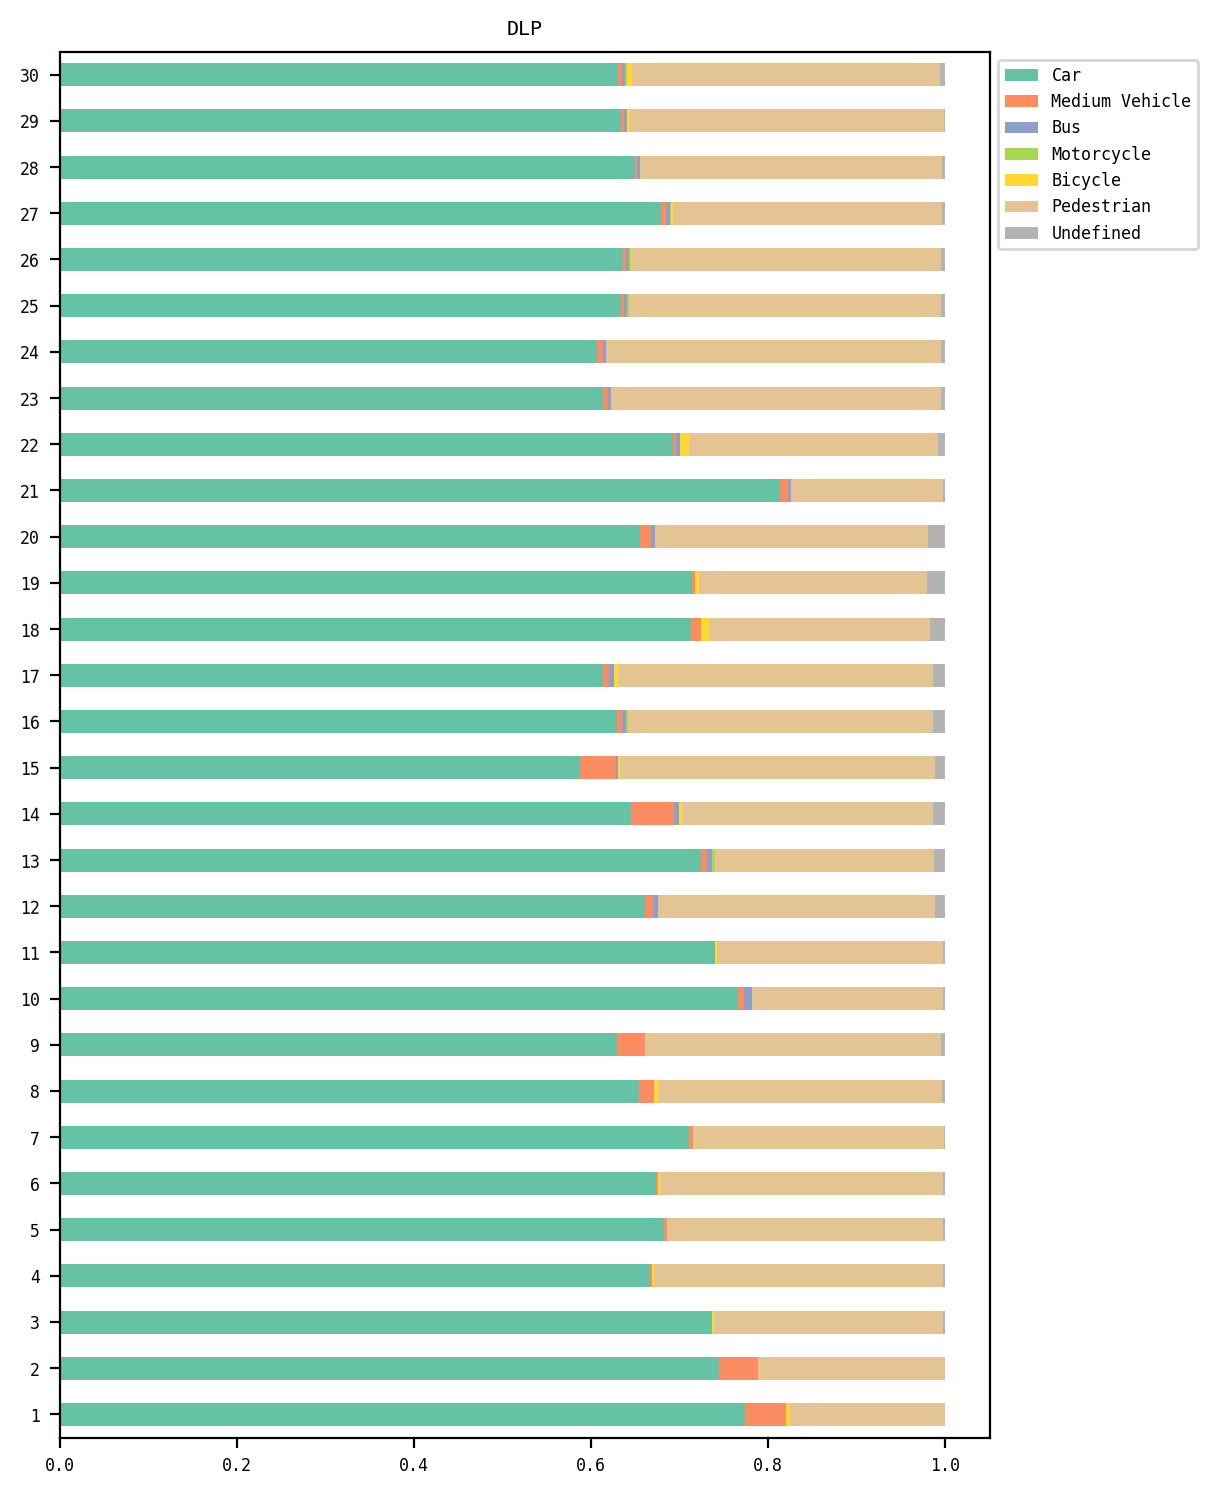

In [5]:
plot_class_proportion(data_path, trajectory_class, map_config)

### Distribution of Average Speed on Map

The following heatmaps illustrate the average speed distribution across the map, divided by grid. Vehicles and pedestrians exhibit notably different movement patterns. Vehicles tend to slow down at corners and accelerate along straight paths, displaying relatively consistent behavior. In contrast, pedestrians show greater spatial dispersion and significant individual variation in walking direction and speed.

In [6]:
def plot_speed_distribution(map_range: list, data_path: str, class_: str, map_config: dict, vmax: float = 10):
    x_min, x_max, y_min, y_max = map_range
    matrix_x = int((x_max - x_min) * 5)
    matrix_y = int((y_max - y_min) * 5)
    speed_map = np.zeros((matrix_y, matrix_x, 2))

    for file_id in map_config["trajectory_files"]:
        agent_path = os.path.join(data_path, "DJI_%04d_agents.json" % file_id)
        with open(agent_path, "r") as f_agent:
            agent_data = json.load(f_agent)

        instance_path = os.path.join(data_path, "DJI_%04d_instances.json" % file_id)
        with open(instance_path, "r") as f_instance:
            instance_data = json.load(f_instance)

        obstacle_path = os.path.join(data_path, "DJI_%04d_obstacles.json" % file_id)
        with open(obstacle_path, "r") as f_obstacle:
            obstacle_data = json.load(f_obstacle)

        frame_path = os.path.join(data_path, "DJI_%04d_frames.json" % file_id)
        with open(frame_path, "r") as f_frame:
            frame_data = json.load(f_frame)
        time_steps = len(frame_data)

        for value in instance_data.values():
            if agent_data[value["agent_token"]]["type"] != class_:
                continue

            x = int((value["coords"][0] - x_min) * 5)
            y = int((value["coords"][1] - y_min) * 5)
            if x < 0 or x >= matrix_x or y < 0 or y >= matrix_y:
                continue
            speed_map[y, x, 0] += value["speed"]
            speed_map[y, x, 1] += 1

        for value in obstacle_data.values():
            if value["type"] != class_:
                continue
            x = int((value["coords"][0] - x_min) * 5)
            y = int((value["coords"][1] - y_min) * 5)
            if x < 0 or x >= matrix_x or y < 0 or y >= matrix_y:
                continue
            speed_map[y, x, 1] += time_steps

    speed_map[:, :, 0] /= speed_map[:, :, 1]
    speed_map = np.flip(speed_map, axis=0)

    im = plt.imshow(speed_map[:, :, 0], cmap="cool", vmin=0, vmax=vmax)
    plt.title(f"Average speed distribution of `{class_}`")
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.gcf().set_figwidth(6)
    cax = plt.gcf().add_axes(
        [
            plt.gca().get_position().x1 + 0.01,
            plt.gca().get_position().y0,
            0.02,
            plt.gca().get_position().height,
        ]
    )
    plt.colorbar(im, cax=cax, label="(m/s)")
    plt.show()

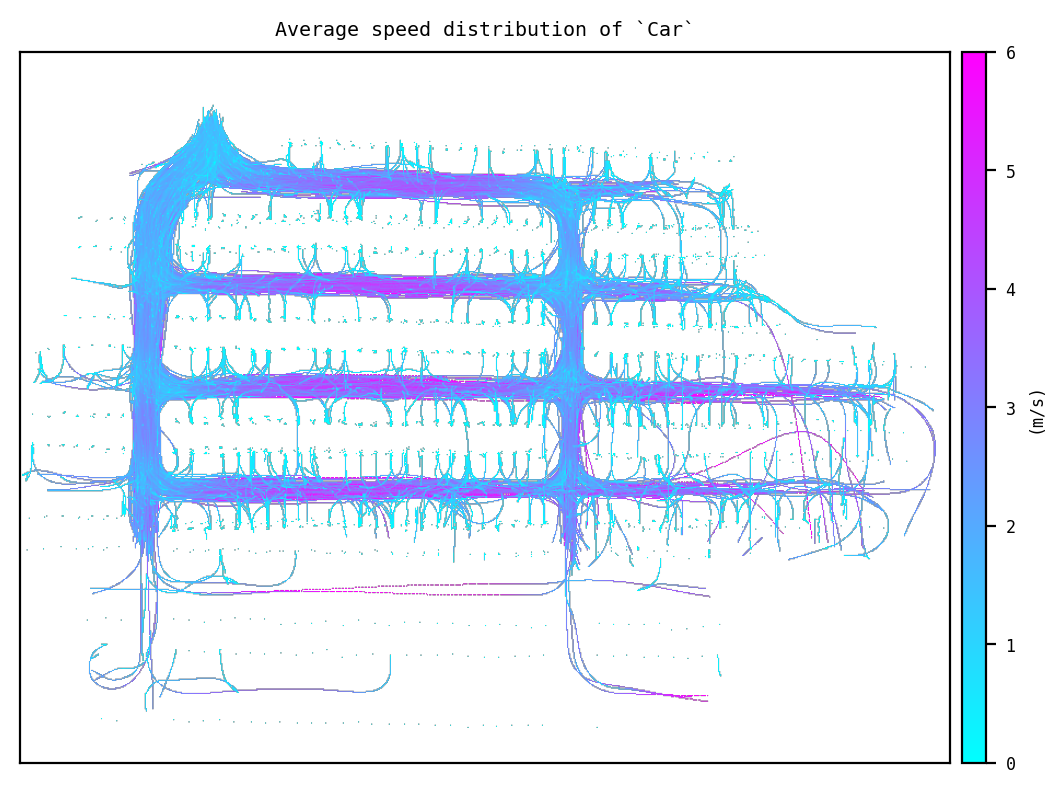

In [7]:
plot_speed_distribution(map_range, data_path, "Car", map_config, vmax=6)

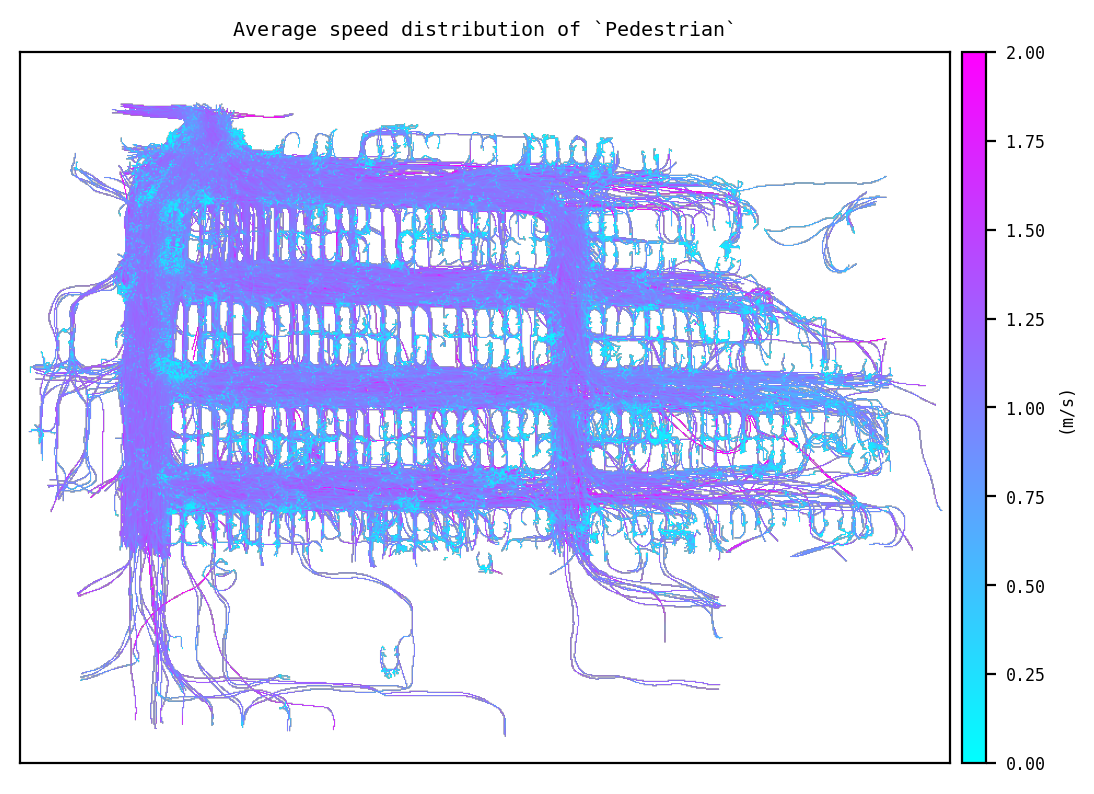

In [8]:
plot_speed_distribution(map_range, data_path, "Pedestrian", map_config, vmax=2)

### Parking Spot Usage

The figure below illustrates how often each parking spot is occupied. It is clear that spots closer to the entrance are preferred and more frequently used.

In [9]:
def plot_parking_density(map_range: list, data_path: str, map_config: dict):
    x_min, x_max, y_min, y_max = map_range
    matrix_x = int(x_max - x_min)
    matrix_y = int(y_max - y_min)
    density_map = np.zeros((matrix_y, matrix_x, 2))

    for file_id in map_config["trajectory_files"]:
        obstacle_path = os.path.join(data_path, "DJI_%04d_obstacles.json" % file_id)
        with open(obstacle_path, "r") as f_obstacle:
            obstacle_data = json.load(f_obstacle)

        for value in obstacle_data.values():
            x = int(value["coords"][0] - x_min)
            y = int(value["coords"][1] - y_min)
            if x < 0 or x >= matrix_x or y < 0 or y >= matrix_y:
                continue
            density_map[y, x, 0] += 1
            density_map[y, x, 1] = 1

    density_map[:, :, 0] /= density_map[:, :, 1]
    density_map = np.flip(density_map, axis=0)

    im = plt.imshow(density_map[:, :, 0], cmap="cool", vmin=0, vmax=30)
    plt.title("The distribution of parking spot usage")
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.gcf().set_figwidth(6)
    cax = plt.gcf().add_axes(
        [
            plt.gca().get_position().x1 + 0.01,
            plt.gca().get_position().y0,
            0.02,
            plt.gca().get_position().height,
        ]
    )
    plt.colorbar(im, cax=cax, label="times")
    plt.show()


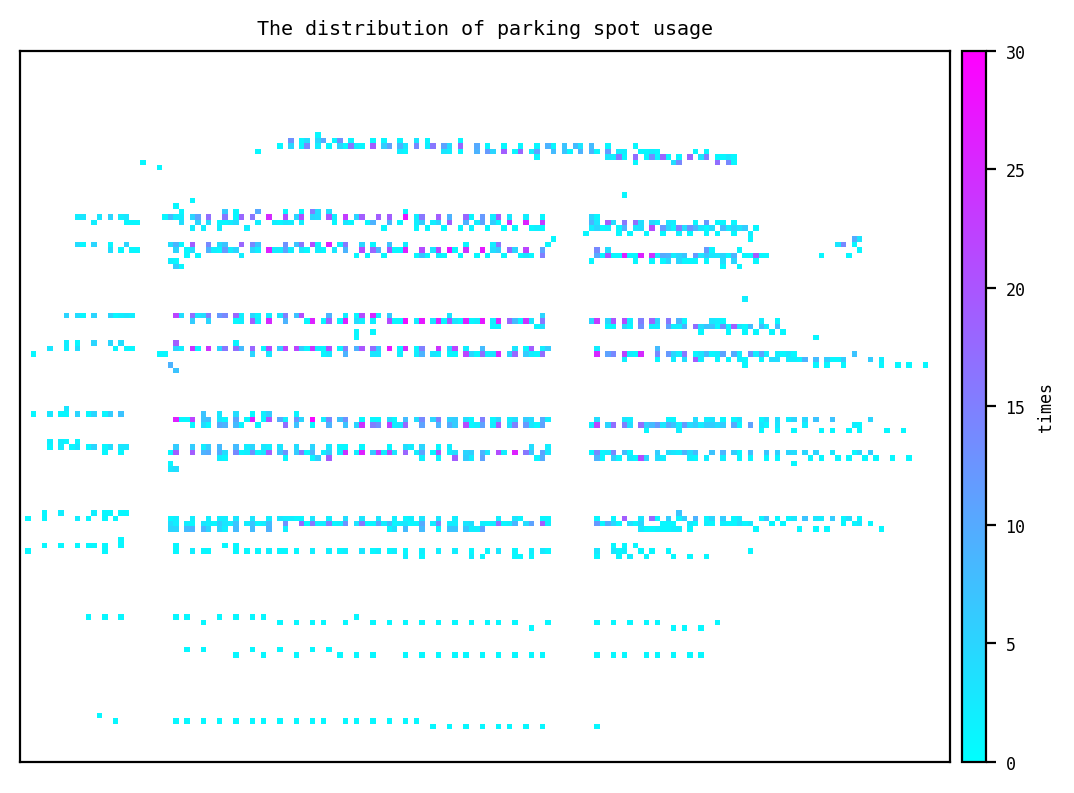

In [10]:
plot_parking_density(map_range, data_path, map_config)

## Tactics2D Integration

This section explains how to parse and replay logs from the DLP dataset by Tactics2D.

### Dataset Preparation

You can place the DLP dataset in any directory of your choice. However, it's recommended to maintain the following folder structure for compatibility.

```shell
DLP
├── 0 README - JSON Data.txt
├── DJI_0001_agents.json
├── DJI_0001_frames.json
├── DJI_0001_instances.json
├── DJI_0001_obstacles.json
├── DJI_0001_scene.json
├── ...
```

### Class Mapping

| DLP Class | Tactics2D Class |
| --- | --- |
| Car | `tactics2d.participant.element.Vehicle` |
| Medium Vehicle | `tactics2d.participant.element.Vehicle` |
| Bus | `tactics2d.participant.element.Vehicle` |
| Motorcycle | `tactics2d.participant.element.Cyclist` |
| Bicycle | `tactics2d.participant.element.Cyclist` |
| Pedestrian | `tactics2d.participant.element.Pedestrian` |
| Undefined | `tactics2d.participant.element.Other` |

### Parse and Replay Logs

To parse, replay, and visualize the highD dataset using Tactics2D, you can use the following code snippet:

In [11]:
%matplotlib notebook

import os
import numpy as np
from matplotlib.animation import FuncAnimation
from shapely.geometry import Point
from IPython.display import HTML

from tactics2d.dataset_parser import DLPParser
from tactics2d.map.parser import OSMParser
from tactics2d.map.map_config import DLP_MAP_CONFIG
from tactics2d.sensor import BEVCamera
from tactics2d.renderer import MatplotlibRenderer

2025-06-26 19:59:20.460617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
path_dataset = "../../data/DLP"  # Replace with your dataset path
path_map = "../../data/DLP_map"  # Replace with your map path
dataset_parser = DLPParser()
map_parser = OSMParser(lanelet2=True)

In [13]:
def render_nuplan(map_, participants, map_boundary, stamp_range, resolution):
    x_min, x_max, y_min, y_max = map_boundary
    camera_position = np.array([0, 0])
    camera = BEVCamera(id_=0, map_=map_)

    renderer = MatplotlibRenderer(xlim=(x_min, x_max), ylim=(y_min, y_max), resolution=resolution)

    fig = renderer.fig  # Use the one already created
    frame_list = list(range(stamp_range[0], stamp_range[1], 40))
    prev_road_id_set = set()
    prev_participant_id_set = set()

    def update(frame):
        nonlocal prev_road_id_set, prev_participant_id_set

        participant_ids = [pid for pid, p in participants.items() if p.is_active(frame)]

        geometry_data, prev_road_id_set, prev_participant_id_set = camera.update(
            frame,
            participants,
            participant_ids,
            prev_road_id_set,
            prev_participant_id_set,
            Point(camera_position),
        )

        renderer.update(geometry_data, camera_position)
        renderer.ax.set_title(f"Frame: {frame}")

    ani = FuncAnimation(fig, update, frames=frame_list, interval=40, repeat=True)
    return ani

In [14]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=3, folder=path_dataset, stamp_range=(0, 8000)
)
map_ = map_parser.parse(
    file_path=os.path.join(path_map, "DLP.osm"), configs=DLP_MAP_CONFIG["DLP"]
)

print(f"Map boundary of DLP location 0: {map_.boundary}.")

boundary = (map_.boundary)
print(f"Map range we display: {boundary}")

ani = render_nuplan(map_, participants, boundary, actual_stamp_range, resolution=(2000, 1000))
HTML(ani.to_html5_video())

Map boundary of DLP location 0: (3.0, 139.0, 0.0, 77.0).
Map range we display: (3.0, 139.0, 0.0, 77.0)


<IPython.core.display.Javascript object>

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:figure size in inches has been adjusted from 10.0 x 5.661764705882353 to 10.0 x 5.66
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2000x1132 -pix_fmt rgba -framerate 25.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpfh7olthv/temp.m4v


## Appendix: Data Format

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        This is a backup copy of 
        <a href="https://datadryad.org/dataset/doi:10.5061/dryad.tht76hf5b#readme" target="_blank" rel="noopener noreferrer">
            the official documentation
        </a>, provided here for reference purposes only.
    </p>
</div>

### Statistics

#### Raw video

Length: 3.5 hours
Resolution: 4K
Frame rate: 25 fps

#### Parking Area

Size: 140 m x 80 m
Number of spots: ~400

#### Agent Types and Count

Vehicles (normal sedan, medium vehicle like SUV, bus): 1216
Pedestrians: 3904
Bicycles: 28
Motorcycles: 5

### Description of the data and file structure

The raw videos are annotated and converted to JSON format. The dataset has a graph structure with the following components

- Agent: An agent is an object that has moved in this scene. It contains the object’s dimension, type, and trajectory as a list of instances.
- Instance: An instance is the state of an agent at a time step, which includes position, orientation, velocity, and acceleration. It also points to the preceding / subsequent instance along the agent’s trajectory.
- Frame: A frame is a discrete sample from the recording. It contains a list of visible instances at this time step, and points to the preceding / subsequent frame.
- Obstacle: Obstacles are vehicles that never move in this recording.
- Scene: A scene represents a consecutive video recording with certain length. It points to all frames, agents, and obstacles in this recording.

The entire DLP dataset contains 30 scenes, 317,873 frames, 5,188 agents, and 15,383,737 instances.

### Sharing/Access information

Two types of data are available:

1. JSONs will provide you all Instances, Agents, Frames, Obstacles, and Scene data so that you can use our Python toolkit. All coordinates are transformed from UTM to the local coordinates of the parking lot. You can download the JSONs directly from Dryad if your research is about trajectory analysis and/or semantic visualization is enough for your computer vision module.
2. Raw video and ground truth annotation. You ONLY need this if you are working on object detection, tracking, semantic segmentation, or end-to-end models with raw bird’s eye view camera data. The annotated trajectories are in UTM coordinates. Please understand that we cannot offer software tools for parsing these data. Since the video data is huge, you have to submit [a request](https://forms.gle/Fw5EKy2cKeYCBssF9) if you need raw videos for your research.